In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from geometricus_deep_learning import utils, embedder
import matplotlib.pyplot as plt
import torch
from glob import glob
import pprint
from captum.attr import Saliency, IntegratedGradients

In [3]:
import dataclasses

In [4]:
# First we define the type of moment invariants to be used in geometricus. Here I defined two, one is using 
# kmer splits and the other is using radius method to extract coordinates. Moment types for both include all
# implemented moment invariant types (16 of them)

invariant_types = [utils.InvariantType(type=embedder.SplitType.KMER, 
                                          k=30, moment_types=None),
                   utils.InvariantType(type=embedder.SplitType.KMER, 
                                          k=15, moment_types=None),
                   utils.InvariantType(type=embedder.SplitType.RADIUS, 
                                          k=10, moment_types=None)]

In [5]:
# grab the pdb files and use them as ids

pdb_ids = {x.split("/")[-1] for x in glob("data/smallset/*")}
len(pdb_ids)

2190

In [6]:
# Add labels if needed later (not used in training)

label_mapping = {k: "test" for k in pdb_ids}

In [7]:
# Create and train the model with InfoGraph. this takes some time..

emb = embedder.GeometricusGraphEmbedder.fit("./data/smallset/", invariant_types, label_mapping,
                                            epochs=50, file_output_path="./models/new/",
                                            learning_rate=0.001, number_of_batches=128,
                                            hidden_channels=50)

lr: 0.001
num_features: 48
hidden_dim: 50
num_gc_layers: 3
===== Before training =====
===== Epoch 1, Loss 24225.529717078574 =====
===== Epoch 2, Loss 10267.860352736254 =====
===== Epoch 3, Loss 5764.165974543645 =====
===== Epoch 4, Loss 4076.9702653151294 =====
===== Epoch 5, Loss 3252.134001511794 =====
===== Epoch 6, Loss 2615.9239243727466 =====
===== Epoch 7, Loss 2250.4667147122896 =====
===== Epoch 8, Loss 2102.595017653245 =====
===== Epoch 9, Loss 1830.1959143418533 =====
===== Epoch 10, Loss 1468.84340432974 =====
===== Epoch 11, Loss 1547.8094130295974 =====
===== Epoch 12, Loss 1311.0937262315017 =====
===== Epoch 13, Loss 1165.255940070519 =====
===== Epoch 14, Loss 1231.7721328735352 =====
===== Epoch 15, Loss 1156.000204233023 =====
===== Epoch 16, Loss 1106.7076336787297 =====
===== Epoch 17, Loss 1002.4924821120042 =====
===== Epoch 18, Loss 962.9946201031024 =====
===== Epoch 19, Loss 1087.5269644810603 =====
===== Epoch 20, Loss 1161.260898590088 =====
===== Epoch

In [4]:
emb = embedder.GeometricusGraphEmbedder.from_model_meta_file("./models/new/meta.pkl")

In [18]:
torch.cuda.empty_cache() # this forces garbage collection

In [19]:
# Some info on the embedding class

dataclasses.asdict(emb.model_meta)

{'model_path': 'models/new/model.pth',
 'pdb_folder': 'data/smallset',
 'self_path': 'models/new/meta.pkl',
 'id_to_classname_path': 'models/new/class_map.pkl',
 'invariant_types': [{'type': <SplitType.KMER: 1>,
   'k': 30,
   'moment_types': None},
  {'type': <SplitType.KMER: 1>, 'k': 15, 'moment_types': None},
  {'type': <SplitType.RADIUS: 2>, 'k': 10, 'moment_types': None}],
 'original_invariants_file': 'models/new/invariants.pkl',
 'dataset_path': 'models/new/train_set.pkl'}

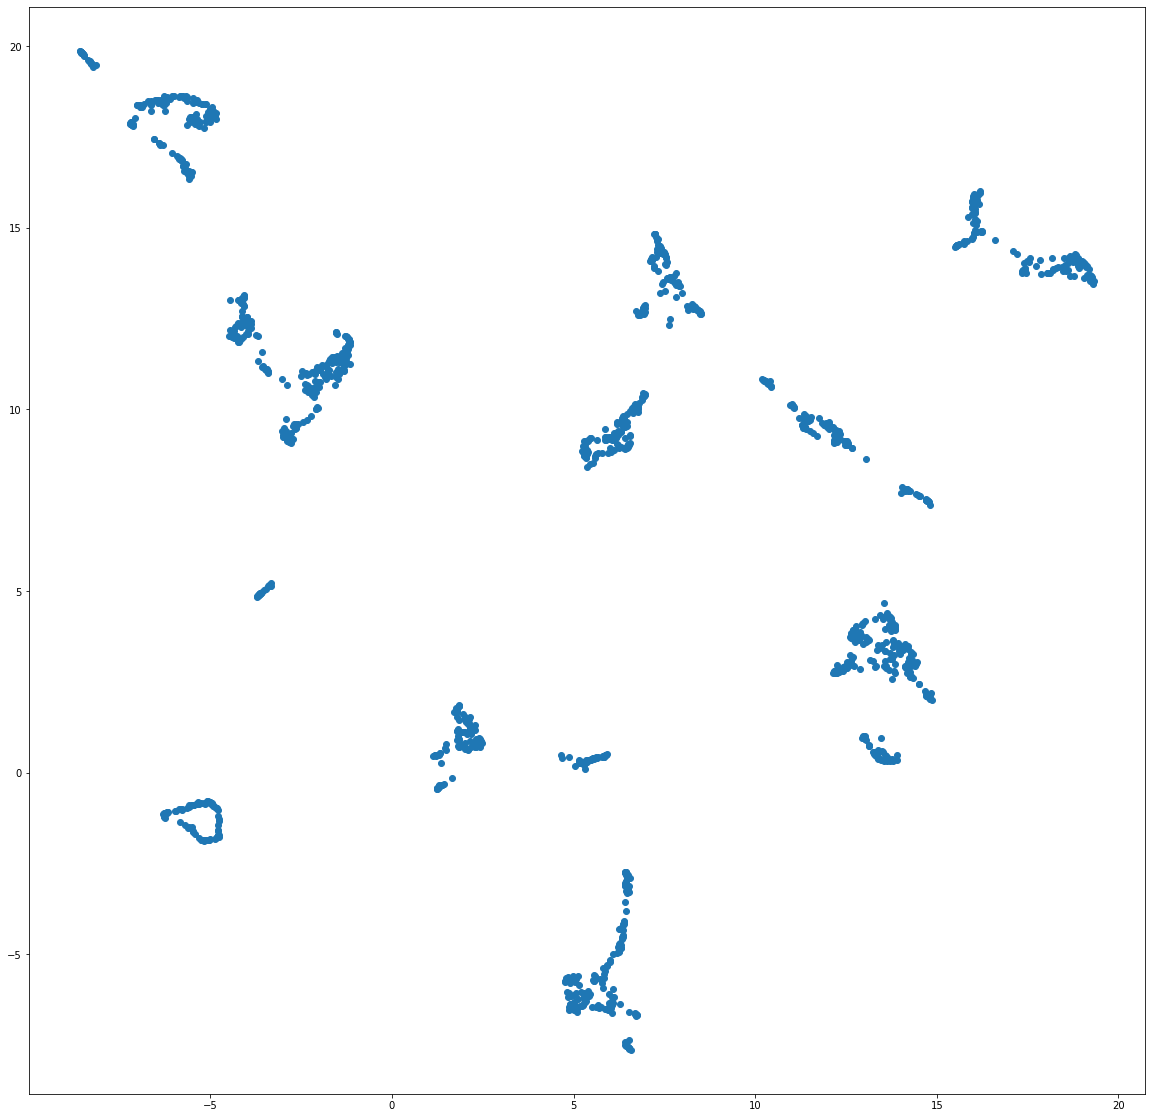

In [20]:
# Here use dimentionality reduction using umap to visualize some clusters

from umap import UMAP

umap_embedding = UMAP().fit_transform(emb.get_self_embedding()[0])

plt.figure(figsize=(20,20))
plt.scatter(
    umap_embedding[:, 0],
    umap_embedding[:, 1])
plt.gca().set_aspect('equal', 'datalim')

In [221]:
import networkx as nx
from torch_geometric.utils import to_networkx


def draw_structure(g, edge_mask=None, draw_edge_labels=False):
    g = g.copy().to_undirected()
    pos = nx.spring_layout(g)
    nx.draw(g, pos=pos,
            node_color=edge_mask)#, node_size=30)
    
    if draw_edge_labels and edge_mask is not None:
        edge_labels = {k: ('%.2f' % v) for k, v in edge_mask.items()}    
        nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels,
                                    font_color='red')

def to_structure(data):
    g = to_networkx(data, node_attrs=['x'])
    for u, data in g.nodes(data=True):
        data['name'] = f"{u}"
        del data["x"]
    return g


In [222]:

def model_forward(x, data):
    batch = torch.zeros(data.x.shape[0], dtype=int).to("cuda")
    out = emb.model(data.x, data.edge_index, batch, None)[1]
    return out


def explain(method, data, target=0):
    if method == 'ig':
        ig = IntegratedGradients(model_forward)
        mask = ig.attribute(data.x, target=target,
                            additional_forward_args=(data, ),
                            internal_batch_size=data.edge_index.shape[1])
    elif method == 'saliency':
        saliency = Saliency(model_forward)
        mask = saliency.attribute(data.x, 
                                  target=target,
                                  additional_forward_args=(data, )
                                 )
    else:
        raise Exception('Unknown explanation method')

    edge_mask = np.abs(mask.cpu().detach().numpy())
    if edge_mask.max() > 0:  # avoid division by zero
        edge_mask = edge_mask / edge_mask.max()
    return edge_mask

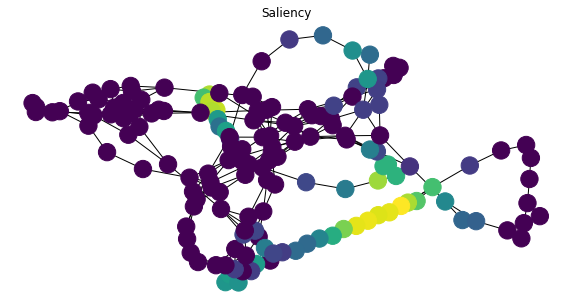

In [223]:
import random
from collections import defaultdict

data = random.choice([t for t in emb.train_set.dataset if not t.y.item()]).to("cuda")
mol = to_structure(data)
for title, method in [('Saliency', 'saliency')]: # , ('Integrated Gradients', 'ig')]:
    edge_mask = explain(method, data, target=0)
    
    edge_mask_dict = aggregate_edge_directions(edge_mask, data)
    plt.figure(figsize=(10, 5))
    plt.title(title)
    draw_structure(mol, [x.mean() for x in edge_mask])
    plt.show()